In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pickle
import time
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
from bokeh.palettes import Set1_7
import scipy
import datetime
import decimal

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

from matplotlib.patches import Ellipse

In [12]:
F = '/home/narsi/Documents/CSEE5690_data/PaloAlto/UMKC-Palo-5Nov-to-9Nov.csv'
T = pd.read_csv(F)
log_size = len(T)
Country_code = pd.read_json('http://techslides.com/demos/country-capitals.json')

In [3]:
def shoot(lon, lat, azimuth, maxdist=None):
    """Shooter Function
    Original javascript on http://williams.best.vwh.net/gccalc.htm
    Translated to python by Thomas Lecocq
    """
    glat1 = lat * np.pi / 180.
    glon1 = lon * np.pi / 180.
    s = maxdist / 1.852
    faz = azimuth * np.pi / 180.
 
    EPS= 0.00000000005
    if ((np.abs(np.cos(glat1))<EPS) and not (np.abs(np.sin(faz))<EPS)):
        alert("Only N-S courses are meaningful, starting at a pole!")
 
    a=6378.13/1.852
    f=1/298.257223563
    r = 1 - f
    tu = r * np.tan(glat1)
    sf = np.sin(faz)
    cf = np.cos(faz)
    if (cf==0):
        b=0.
    else:
        b=2. * np.arctan2 (tu, cf)
 
    cu = 1. / np.sqrt(1 + tu * tu)
    su = tu * cu
    sa = cu * sf
    c2a = 1 - sa * sa
    x = 1. + np.sqrt(1. + c2a * (1. / (r * r) - 1.))
    x = (x - 2.) / x
    c = 1. - x
    c = (x * x / 4. + 1.) / c
    d = (0.375 * x * x - 1.) * x
    tu = s / (r * a * c)
    y = tu
    c = y + 1
    while (np.abs (y - c) > EPS):
 
        sy = np.sin(y)
        cy = np.cos(y)
        cz = np.cos(b + y)
        e = 2. * cz * cz - 1.
        c = y
        x = e * cy
        y = e + e - 1.
        y = (((sy * sy * 4. - 3.) * y * cz * d / 6. + x) *
              d / 4. - cz) * sy * d + tu
 
    b = cu * cy * cf - su * sy
    c = r * np.sqrt(sa * sa + b * b)
    d = su * cy + cu * sy * cf
    glat2 = (np.arctan2(d, c) + np.pi) % (2*np.pi) - np.pi
    c = cu * cy - su * sy * cf
    x = np.arctan2(sy * sf, c)
    c = ((-3. * c2a + 4.) * f + 4.) * c2a * f / 16.
    d = ((e * cy * c + cz) * sy * c + y) * sa
    glon2 = ((glon1 + x - (1. - c) * d * f + np.pi) % (2*np.pi)) - np.pi    
 
    baz = (np.arctan2(sa, b) + np.pi) % (2 * np.pi)
 
    glon2 *= 180./np.pi
    glat2 *= 180./np.pi
    baz *= 180./np.pi
 
    return (glon2, glat2, baz)
 
def equi(m, centerlon, centerlat, radius, *args, **kwargs):
    glon1 = centerlon
    glat1 = centerlat
    X = []
    Y = []
    for azimuth in range(0, 360):
        glon2, glat2, baz = shoot(glon1, glat1, azimuth, radius)
        X.append(glon2)
        Y.append(glat2)
    X.append(X[0])
    Y.append(Y[0])
 
    #m.plot(X,Y,**kwargs) #Should work, but doesn't...
    X,Y = m(X,Y)
    plt.plot(X,Y,**kwargs)

In [31]:
T['Source Country'][T['Source Country'] == '10.0.0.0-10.255.255.255'] = 'MOKC'
T['Destination Country'][T['Destination Country'] == '10.0.0.0-10.255.255.255'] = 'MOKC'

/home/narsi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/narsi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [10]:
SC = pd.Series.value_counts(T['Source Country'][(T['Source Country'] != 'Unknown') & (T['Source Country'] != '0.0.0.0-0.255.255.255')])
DC = pd.Series.value_counts(T['Destination Country'][(T['Destination Country'] != 'Unknown') & (T['Destination Country'] != '0.0.0.0-0.255.255.255')])

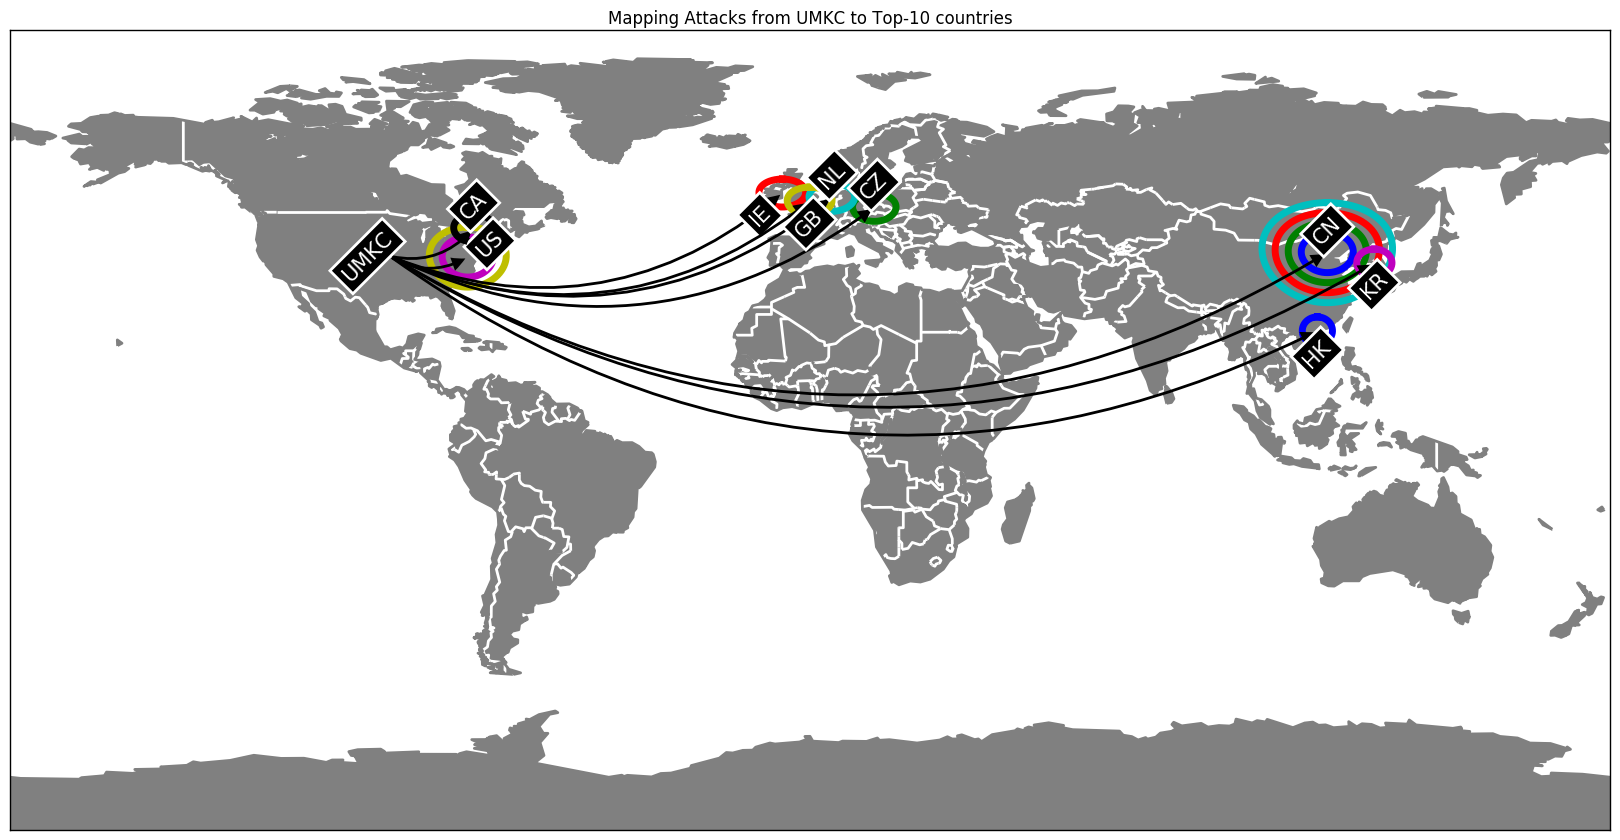

In [37]:
# MAP initialization
# create new figure, axes instances.
fig=plt.figure(figsize=(20,10))
ax=fig.add_axes([0.1,0.1,0.8,0.8])
# setup mercator map projection.
m = Basemap()
m.drawcountries(color='white',linewidth=2)
m.fillcontinents(color='grey',lake_color='white')
m.drawcoastlines(color='grey',linewidth=2)

KC_MO = [39.125212,-94.551136]
US = [38.9072, -77]
HK = [22.28552, 114.15769]
#Collecting log and lat for Source Countries
C = 1.0
radii = [350] + list(range(500,5001,250))
move = 5
el = Ellipse((20, -10), 5.0, 5.0)
for i in ['MOKC']:
    for j in DC.index.values[0:10]:
        # If source is University
        lon_src = KC_MO[1]
        lat_src = KC_MO[0]
        
        # Destination Info
        
        # If source is University
        if j == 'MOKC':
            lon_dst = KC_MO[1]
            lat_dst = KC_MO[0]
            name_dst = 'UMKC'
        elif j == 'US':
            lon_dst = US[1]
            lat_dst = US[0]
            name_dst = 'USA'
        elif j == 'HK':
            lon_dst = HK[1]
            lat_dst = HK[0]
            name_dst = 'Hong Kong'
        else:
            name_dst = list(Country_code['CountryName'][Country_code['CountryCode'] == j])[0]
            lon_dst = float(list(Country_code['CapitalLongitude'][Country_code['CountryCode'] == j])[0])
            lat_dst = float(list(Country_code['CapitalLatitude'][Country_code['CountryCode'] == j])[0])
        num_attacks = pd.Series.value_counts(T['Source Country'][(T['Source Country'] == i) & (T['Destination Country'] == j)])
        
        if list(num_attacks) != []:
            x,y = m( lon_src,lat_src)
            x2, y2 = m(lon_dst,lat_dst)
            num_attacks = num_attacks[i]
            num_circle = int((num_attacks*1.0/log_size*1.0)*10)
            start_circle = 1
            if num_circle == 1:
                start_circle = 1
                num_circle = 2
            elif num_circle == 0:
                start_circle = 0
                num_circle = 1
            else:
                num_circle += 1
            
            
            for k in radii[start_circle:num_circle]:
                equi(m, x2, y2,k,lw=5.)
            
            plt.annotate('', xy=(x2, y2),  xycoords='data',
                    xytext=(x, y), textcoords='data',
                    arrowprops=dict(arrowstyle="simple,head_length=1,head_width=1",
                                fc="black", ec="none",
                                patchB=el,
                                connectionstyle="arc3,rad=0.3")
                    )
            if C%2 == 0:
                move = -5
            else:
                move = 5
            if j == 'US':
                move = 3
                x2 += 5
            if j == 'GB':
                move = -5
            if j == 'IE':
                x2 -= 5
            
            C += 1
            
            bbox_props = dict(boxstyle="square,pad=0.3", fc="black", ec="white", lw=2)
            t = ax.text(x2, y2+move, j, ha="center", va="center", rotation=45,color='white',
                size=15,bbox=bbox_props)
            

bbox_props = dict(boxstyle="square,pad=0.3", fc="black", ec="white", lw=2)
t = ax.text(x-5,y, 'UMKC', ha="center", va="center", rotation=45,color='white',
                size=15,bbox=bbox_props)            
ax.set_title('Mapping Attacks from UMKC to Top-10 countries')
plt.show()        

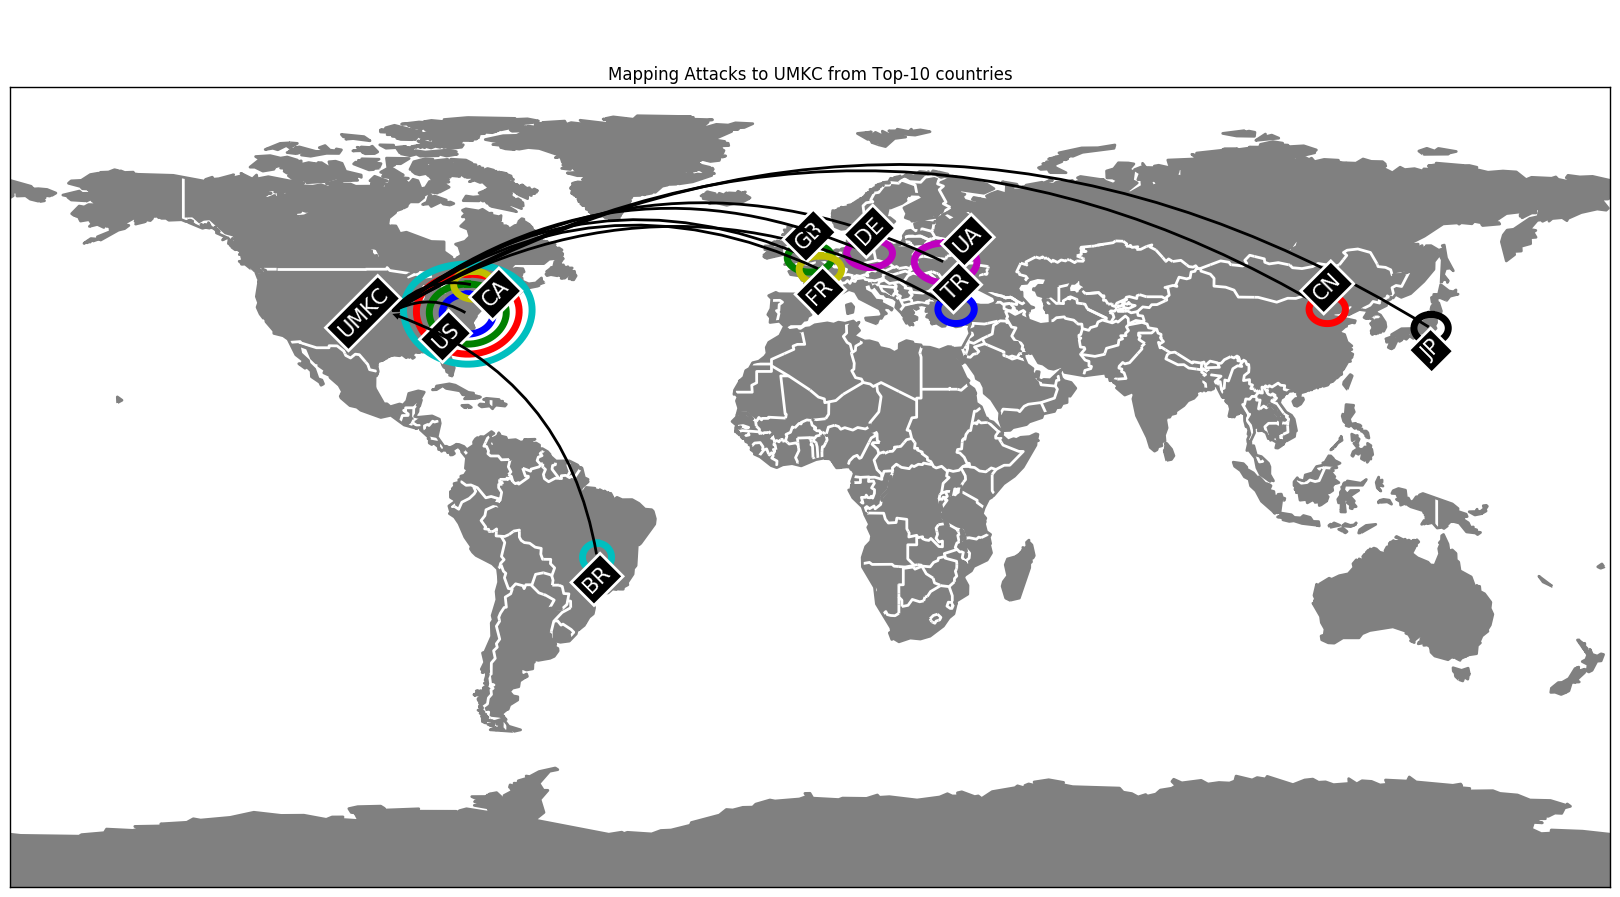

In [36]:
# MAP initialization
# create new figure, axes instances.
fig=plt.figure(figsize=(20,10))
ax=fig.add_axes([0.1,0.1,0.8,0.8])
# setup mercator map projection.
m = Basemap()
m.drawcountries(color='white',linewidth=2)
m.fillcontinents(color='grey',lake_color='white')
m.drawcoastlines(color='grey',linewidth=2)

KC_MO = [39.125212,-94.551136]
US = [38.9072, -77]
HK = [22.28552, 114.15769]
# Collecting log and lat for Source Countries
C = 1.0
radii = [350] + list(range(500,5001,250))
move = 5
el = Ellipse((-20, 10), 5.0, 5.0)
for i in SC.index.values[1:11]:
    for j in ['MOKC']:
        # If source is University
        if i == 'MOKC':
            lon_src = KC_MO[1]
            lat_src = KC_MO[0]
        elif i == 'US':
            lon_src = US[1]
            lat_src = US[0]
        else:
            lon_src = float(list(Country_code['CapitalLongitude'][Country_code['CountryCode'] == i])[0])
            lat_src = float(list(Country_code['CapitalLatitude'][Country_code['CountryCode'] == i])[0])
        
        # Destination Info
        
        lon_dst = KC_MO[1]
        lat_dst = KC_MO[0]
        num_attacks1 = pd.Series.value_counts(T['Source Country'][(T['Source Country'] == i) & (T['Destination Country'] == j)])
        num_attacks2 = pd.Series.value_counts(T['Source Country'][(T['Source Country'] == i) & (T['Destination Country'] == 'US')])
        
        if (list(num_attacks1) != []) or ((list(num_attacks2) != [])):
            x,y = m( lon_src,lat_src)
            x2, y2 = m(lon_dst,lat_dst)
            if list(num_attacks1) == []:
                num_attacks1 = 0.0
            else:
                num_attacks1 = int(num_attacks1[i])
            if list(num_attacks2) == []:
                num_attacks2 = 0.0
            else:
                num_attacks2 = int(num_attacks2[i])
            num_attacks = int(num_attacks1) + int(num_attacks2)
            num_circle = int((num_attacks*1.0/np.sum(SC[1:11])*1.0)*10)
            start_circle = 1
            if num_circle == 1:
                start_circle = 1
                num_circle = 2
            elif num_circle == 0:
                start_circle = 0
                num_circle = 1
            else:
                num_circle += 1
            
            for k in radii[start_circle:num_circle]:
                equi(m, x, y,k,lw=5.)
                            
            plt.annotate('', xy=(x2, y2),  xycoords='data',
                    xytext=(x, y), textcoords='data',
                    arrowprops=dict(arrowstyle="simple",
                                fc="black", ec="none",
                                patchB=el,
                                connectionstyle="arc3,rad=0.3")
                    )
            bbox_props = dict(boxstyle="square,pad=0.3", fc="black", ec="white", lw=2)
            if C%2 == 0:
                move = -5
            else:
                move = 5
            if i == 'CA':
                move = -2
                x += 5
            if i == 'US':
                x -= 5
                move = -5
            if i == 'GB':
                move = +5
            if i == 'IE':
                x -= 5
            if i == 'UA':
                x += 5
                move = 5
            
            C += 1
            
            t = ax.text(x, y+move, i, ha="center", va="center", rotation=45,color='white',
                size=15,bbox=bbox_props)
            

t = ax.text(x2-6,y2, 'UMKC', ha="center", va="center", rotation=45,color='white',
                size=15,bbox=bbox_props)            
ax.set_title('Mapping Attacks to UMKC from Top-10 countries')
plt.show()  